# Training Experiments Analysis

This notebook combines and visualizes results from the training experiments.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Load and Combine All Results

In [2]:
results_dir = Path('../scripts/training_experiments/results')
csv_files = list(results_dir.glob('*_metrics.csv'))

# Load all CSVs
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    # Extract experiment name from filename
    experiment_name = csv_file.stem.replace('_metrics', '')
    df['experiment'] = experiment_name
    dfs.append(df)

# Combine all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(csv_files)} experiment files")
print(f"Total rows: {len(combined_df)}")
print(f"\nExperiments: {combined_df['experiment'].unique().tolist()}")

combined_df.head()

Loaded 8 experiment files
Total rows: 120

Experiments: ['ranker_baseline', 'ranker_both', 'ranker_query_only', 'embedder_baseline', 'ranker_encoder_only', 'embedder_encoder_only', 'embedder_query_only', 'embedder_both']


,epoch,model_type,freeze_encoder,freeze_query,train_loss,val_loss,precision@1,MRR,NDCG@10,score_margin,Recall@1,Recall@3,Recall@5,Recall@10,Recall@20,experiment
0,1,ranker,True,True,0.0,49.656738,0.4500,0.625074,0.655926,2.773006,0.044872,0.138403,0.184649,0.244020,0.522103,ranker_baseline
1,2,ranker,True,True,0.0,49.032660,0.2250,0.465387,0.581491,1.712980,0.044872,0.044872,0.129093,0.296065,0.497744,ranker_baseline
2,3,ranker,True,True,0.0,50.183302,0.4875,0.601190,0.684834,4.670691,0.044872,0.073232,0.156871,0.277140,0.491334,ranker_baseline
3,4,ranker,True,True,0.0,51.554970,0.1875,0.413591,0.550441,-0.327131,0.044872,0.107143,0.203879,0.316364,0.502872,ranker_baseline
4,5,ranker,True,True,0.0,51.129351,0.2250,0.422917,0.575923,0.778214,0.044872,0.077506,0.106657,0.294997,0.468898,ranker_baseline


## Summary Statistics

In [3]:
# Get best epoch for each experiment based on validation loss
best_epochs = combined_df.loc[combined_df.groupby('experiment')['val_loss'].idxmin()]

# Select key metrics
metrics_cols = ['experiment', 'epoch', 'val_loss', 'precision@1', 'MRR', 'NDCG@10',
                'Recall@1', 'Recall@5', 'Recall@10']
summary = best_epochs[metrics_cols].sort_values('val_loss')

print("Best Performance (by validation loss):")
summary

Best Performance (by validation loss):


,experiment,epoch,val_loss,precision@1,MRR,NDCG@10,Recall@1,Recall@5,Recall@10
25,ranker_both,11,0.171355,1.0000,1.000000,0.981937,0.207298,0.614449,0.753469
74,ranker_encoder_only,15,0.216302,0.9375,0.968750,0.945075,0.198751,0.654776,0.882226
106,embedder_both,2,0.309894,1.0000,1.000000,0.984298,0.168837,0.644641,0.836253
78,embedder_encoder_only,4,0.421012,0.9375,0.953125,0.968829,0.207298,0.635026,0.860825
101,embedder_query_only,12,1.400902,0.7125,0.814583,0.832432,0.064103,0.251407,0.455986
47,embedder_baseline,3,2.152164,0.4875,0.654762,0.693648,0.075092,0.251193,0.325216
42,ranker_query_only,13,47.945513,0.0625,0.334931,0.532544,0.044872,0.162213,0.298507
12,ranker_baseline,13,48.725256,0.3875,0.537798,0.640659,0.044872,0.159008,0.269356


## Validation Loss Over Epochs

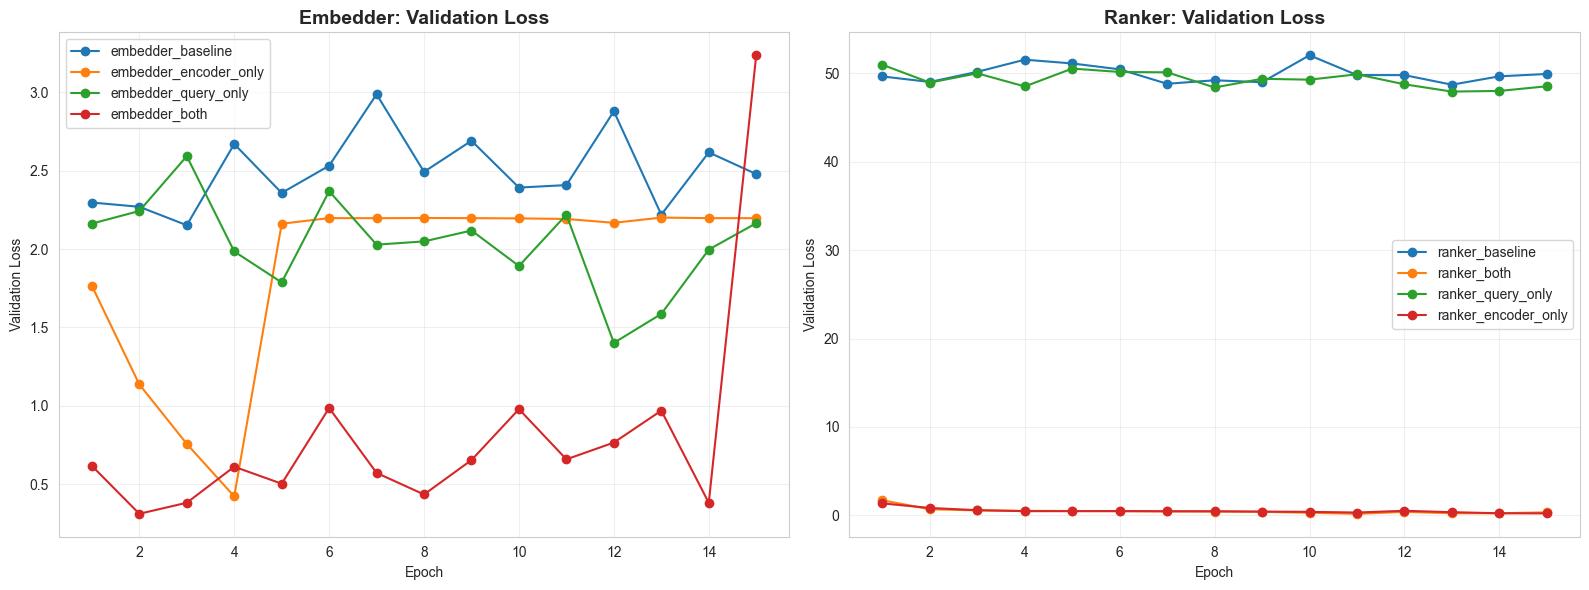

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Embedder experiments
embedder_df = combined_df[combined_df['model_type'] == 'embedder']
for exp in embedder_df['experiment'].unique():
    data = embedder_df[embedder_df['experiment'] == exp]
    axes[0].plot(data['epoch'], data['val_loss'], marker='o', label=exp)
axes[0].set_title('Embedder: Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Ranker experiments
ranker_df = combined_df[combined_df['model_type'] == 'ranker']
for exp in ranker_df['experiment'].unique():
    data = ranker_df[ranker_df['experiment'] == exp]
    axes[1].plot(data['epoch'], data['val_loss'], marker='o', label=exp)
axes[1].set_title('Ranker: Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Recall Metrics Comparison

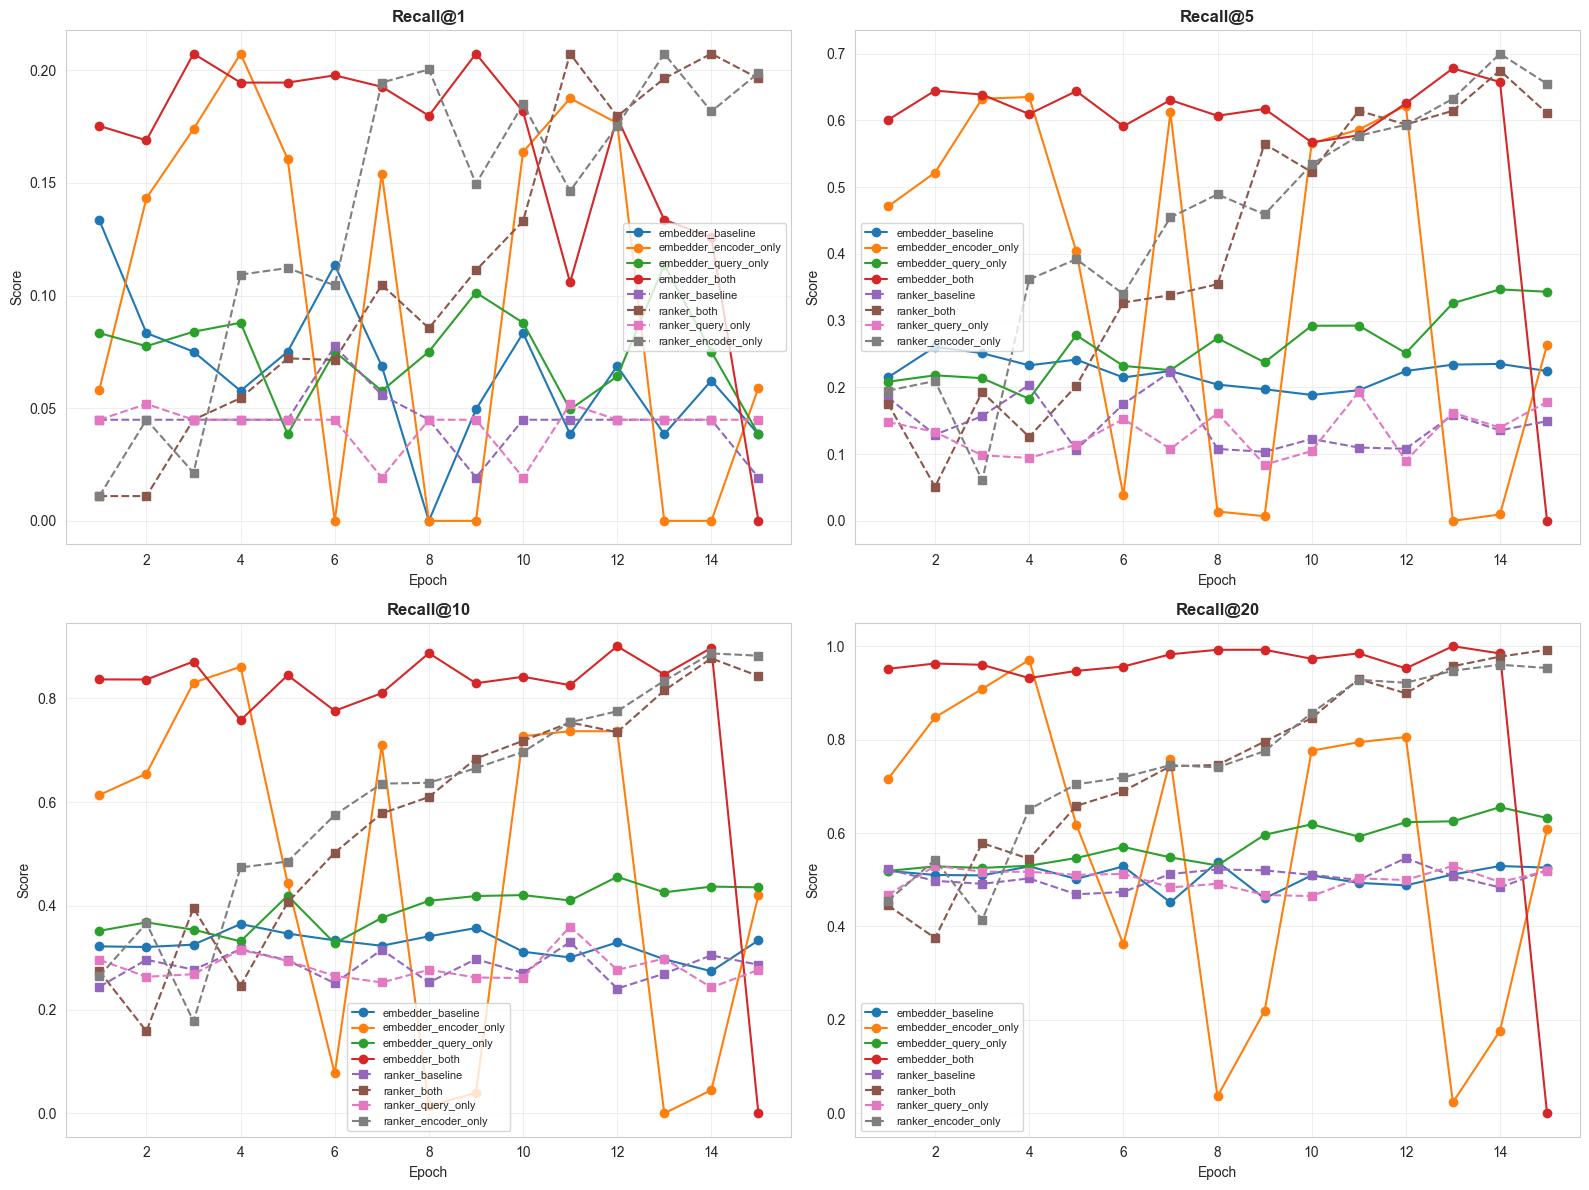

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

recall_metrics = ['Recall@1', 'Recall@5', 'Recall@10', 'Recall@20']

for idx, metric in enumerate(recall_metrics):
    ax = axes[idx // 2, idx % 2]

    # Embedder
    for exp in embedder_df['experiment'].unique():
        data = embedder_df[embedder_df['experiment'] == exp]
        ax.plot(data['epoch'], data[metric], marker='o', linestyle='-', label=f'{exp}')

    # Ranker
    for exp in ranker_df['experiment'].unique():
        data = ranker_df[ranker_df['experiment'] == exp]
        ax.plot(data['epoch'], data[metric], marker='s', linestyle='--', label=f'{exp}')

    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## MRR and NDCG@10 Comparison

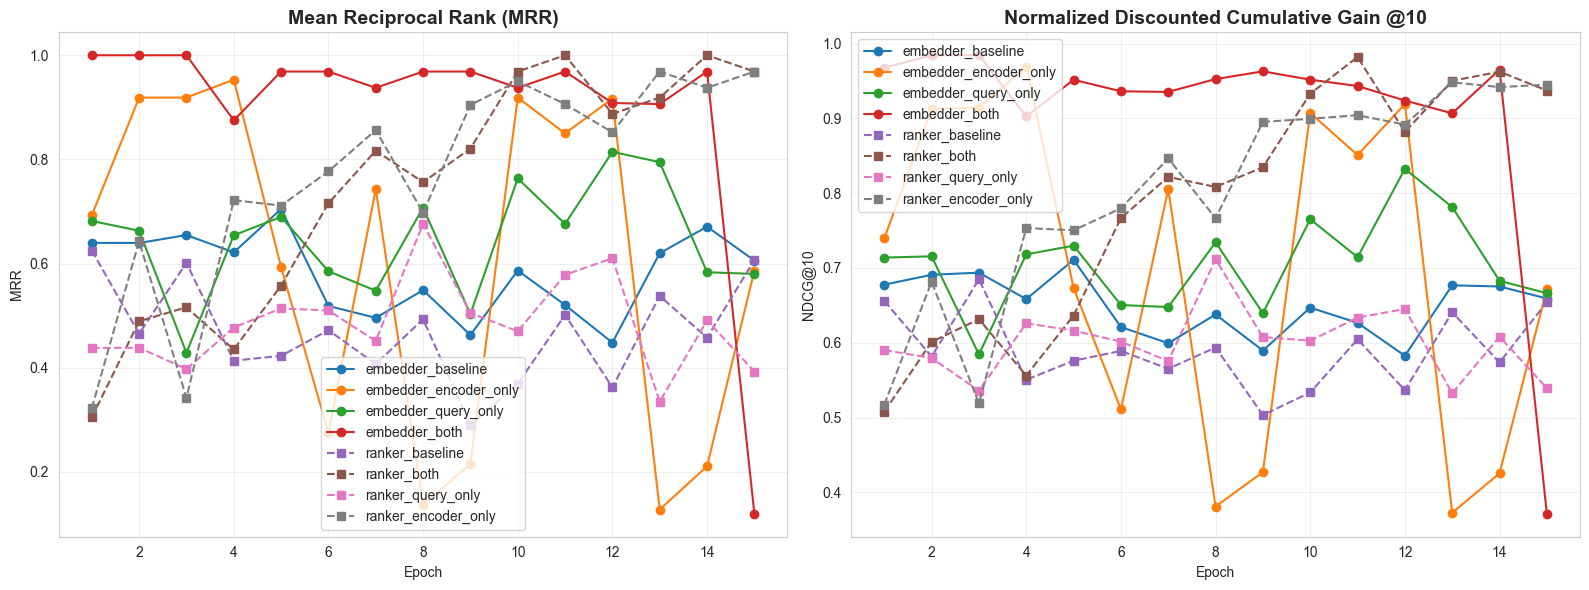

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MRR
for exp in embedder_df['experiment'].unique():
    data = embedder_df[embedder_df['experiment'] == exp]
    axes[0].plot(data['epoch'], data['MRR'], marker='o', linestyle='-', label=exp)
for exp in ranker_df['experiment'].unique():
    data = ranker_df[ranker_df['experiment'] == exp]
    axes[0].plot(data['epoch'], data['MRR'], marker='s', linestyle='--', label=exp)
axes[0].set_title('Mean Reciprocal Rank (MRR)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MRR')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# NDCG@10
for exp in embedder_df['experiment'].unique():
    data = embedder_df[embedder_df['experiment'] == exp]
    axes[1].plot(data['epoch'], data['NDCG@10'], marker='o', linestyle='-', label=exp)
for exp in ranker_df['experiment'].unique():
    data = ranker_df[ranker_df['experiment'] == exp]
    axes[1].plot(data['epoch'], data['NDCG@10'], marker='s', linestyle='--', label=exp)
axes[1].set_title('Normalized Discounted Cumulative Gain @10', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('NDCG@10')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Best Performance Comparison (Bar Chart)

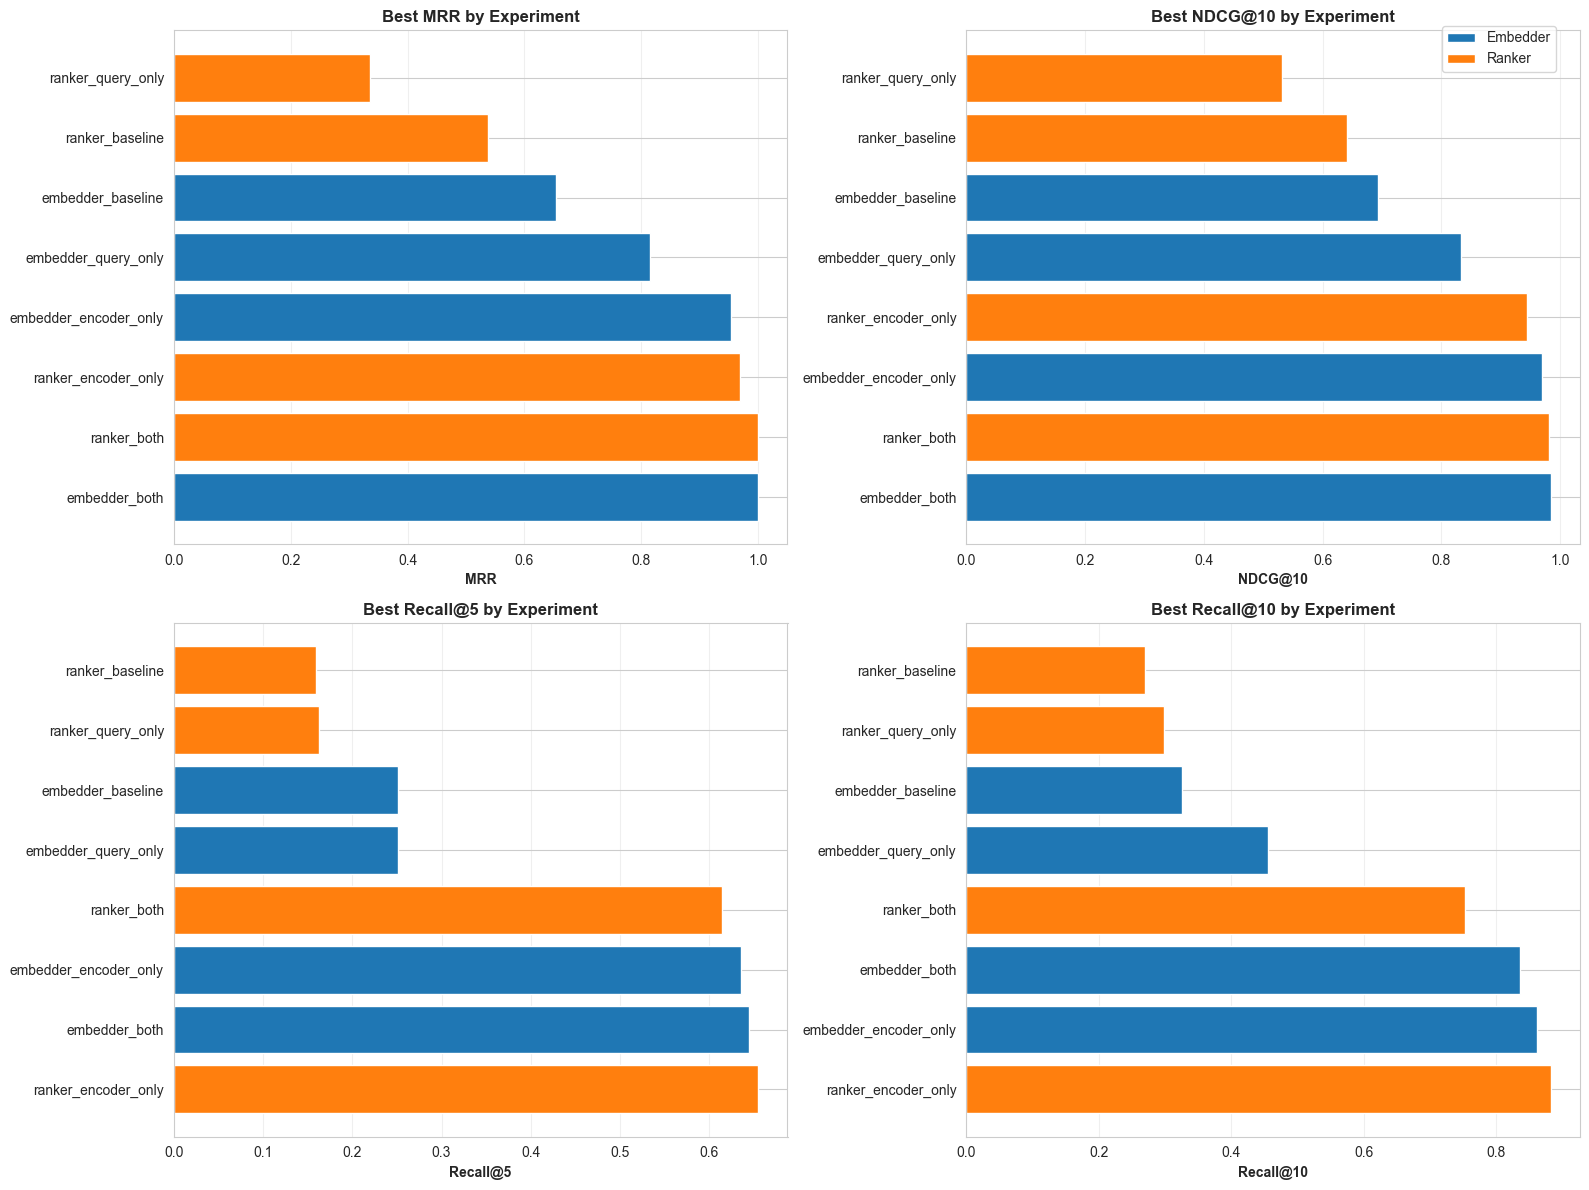

In [7]:
# Create comparison of best epochs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_compare = ['MRR', 'NDCG@10', 'Recall@5', 'Recall@10']

for idx, metric in enumerate(metrics_to_compare):
    ax = axes[idx // 2, idx % 2]

    data = best_epochs.sort_values(metric, ascending=False)

    # Color by model type
    colors = ['#1f77b4' if 'embedder' in exp else '#ff7f0e' for exp in data['experiment']]

    ax.barh(data['experiment'], data[metric], color=colors)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'Best {metric} by Experiment', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1f77b4', label='Embedder'),
                   Patch(facecolor='#ff7f0e', label='Ranker')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()

## Training Configuration Analysis

In [13]:
# Analyze the effect of freezing encoder vs query
config_summary = best_epochs[['experiment', 'model_type', 'freeze_encoder', 'freeze_query',
                               'MRR', 'NDCG@10', 'Recall@20', 'val_loss']].copy()

# Create configuration label
def config_label(row):
    if row['freeze_encoder'] and row['freeze_query']:
        return 'baseline (both frozen)'
    elif not row['freeze_encoder'] and row['freeze_query']:
        return 'encoder_only'
    elif row['freeze_encoder'] and not row['freeze_query']:
        return 'query_only'
    else:
        return 'both'

config_summary['config'] = config_summary.apply(config_label, axis=1)

print("\nPerformance by Configuration:")
config_summary[['model_type', 'config', 'MRR', 'NDCG@10', 'Recall@20', 'val_loss']].sort_values(['Recall@20', 'model_type'], ascending=[False, False])


Performance by Configuration:


,model_type,config,MRR,NDCG@10,Recall@20,val_loss
78,embedder,encoder_only,0.953125,0.968829,0.970629,0.421012
106,embedder,both,1.000000,0.984298,0.962937,0.309894
74,ranker,encoder_only,0.968750,0.945075,0.953322,0.216302
25,ranker,both,1.000000,0.981937,0.929512,0.171355
101,embedder,query_only,0.814583,0.832432,0.623360,1.400902
42,ranker,query_only,0.334931,0.532544,0.529795,47.945513
47,embedder,baseline (both frozen),0.654762,0.693648,0.509404,2.152164
12,ranker,baseline (both frozen),0.537798,0.640659,0.507909,48.725256


## Save Combined Results

In [9]:
# Save combined results
output_path = results_dir / 'combined_results.csv'
combined_df.to_csv(output_path, index=False)
print(f"Combined results saved to: {output_path}")

# Save best epochs summary
summary_path = results_dir / 'best_performance_summary.csv'
best_epochs.to_csv(summary_path, index=False)
print(f"Best performance summary saved to: {summary_path}")

Combined results saved to: ../scripts/training_experiments/results/combined_results.csv
Best performance summary saved to: ../scripts/training_experiments/results/best_performance_summary.csv
